Import the libraries necessary to analize data

In [371]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random

from collections import defaultdict
from scipy.stats import pearsonr

# Incidents

Import the incidents csv file

In [372]:
df = pd.read_csv('incidents_df_joined.csv', low_memory=False, sep=',', parse_dates=['date']) #alternative in case of json source df.to_json('filename.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199379 non-null  datetime64[ns]
 1   state                      199379 non-null  object        
 2   city_or_county             199379 non-null  object        
 3   address                    185728 non-null  object        
 4   latitude                   199313 non-null  float64       
 5   longitude                  199313 non-null  float64       
 6   congressional_district     199379 non-null  float64       
 7   state_house_district       178208 non-null  float64       
 8   state_senate_district      184240 non-null  float64       
 9   participant_age1           136187 non-null  float64       
 10  participant_age_group1     161305 non-null  object        
 11  participant_gender1        166716 non-null  object  

Change data types to match the content of each attribute

In [373]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("float64")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_gender1"] = df["participant_gender1"].astype("string")
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Int64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Int64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Int64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Int64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Int64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Int64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Int64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136186 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string  

Deleting the rows with all NaN values

In [374]:
print(f"df len before: {len(df)}")
df.dropna(how='all', inplace=True)
print(f"df len after: {len(df)}")

df len before: 199379
df len after: 199378


Removing negative values

In [375]:
columns_to_check = ['participant_age1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants']
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df.loc[df[i] < 0, i] = np.nan


## Age


As seen in D.U., given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN, considering that a person with more than 120 years has not ever lived [cite, wikipedia].

In [376]:
df.loc[(df["avg_age_participants"] > 120), "avg_age_participants"] = np.nan
df.loc[(df['min_age_participants'] > 120), "min_age_participants"] = np.nan
df.loc[(df['max_age_participants'] > 120), "max_age_participants"] = np.nan
df.loc[(df["participant_age1"] > 120), "participant_age1"] = np.nan

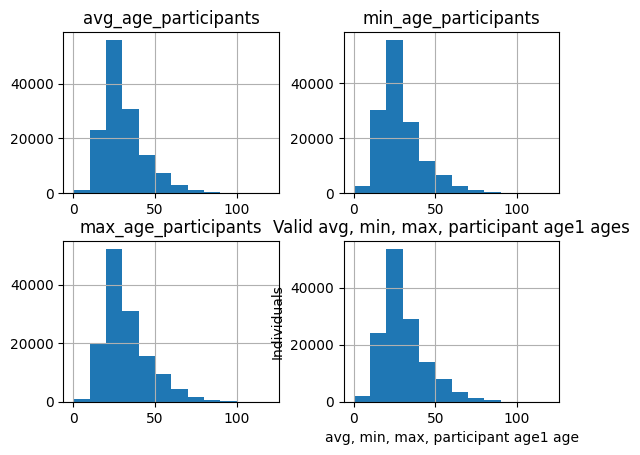

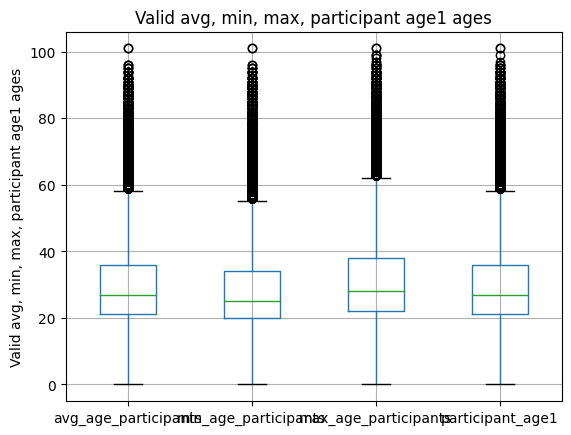

In [377]:

df.hist(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'], bins=[i for i in range(0,121,10)])
plt.title("Valid avg, min, max, participant age1 ages")
plt.xlabel("avg, min, max, participant age1 age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'])
plt.title("Valid avg, min, max, participant age1 ages")
plt.ylabel("Valid avg, min, max, participant age1 ages")
plt.show()

In [378]:
df[['avg_age_participants', 'participant_age1', 'min_age_participants', 'max_age_participants']].describe()

,avg_age_participants,participant_age1,min_age_participants,max_age_participants
count,136184.000000,136184.0,136188.0,136185.0
mean,29.974858,30.260816,28.325763,31.764746
std,12.461499,13.343577,12.498695,13.709934
min,0.000000,0.0,0.0,0.0
25%,21.000000,21.0,20.0,22.0
50%,27.000000,27.0,25.0,28.0
75%,36.000000,36.0,34.0,38.0
max,101.000000,101.0,101.0,101.0


We notice from eliminated obvious outliers (>120 and <0 years of age) and plotting the results that [avg_age,min_age,max_age]_participants are very similar (same min and max age, similar mean and median), so we decide that we will further explore their correlation. 

#TODO: understand what this control mean

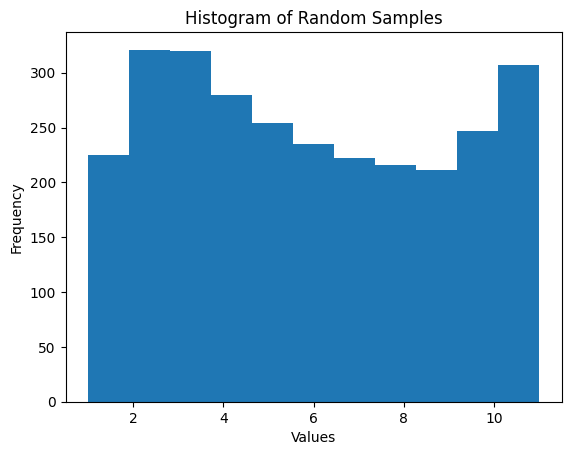

In [379]:
#df.loc[(pd.isna(df["date"])), "date"] = np.random.choice(df["date"].dropna(), size=len(df[pd.isna(df["date"])]))
condition = (df["min_age_participants"] < 12) & (df["min_age_participants"] > 0)
random_row = np.random.choice(df.loc[condition]["min_age_participants"], size=len(df.loc[condition]))
plt.hist(random_row, bins=11)  # You can adjust the number of bins as needed
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of Random Samples")
plt.show()
#Abbiamo osservato la distrubuzione di "min_age_participants" tra 0 e 11 per poter sostituire i valori di "min_ag_participants" che sono a null e che ricadono nella condizione per cui "n_participant_childs" è non negativo e > 0
#Ragionamento analogo per i valori con "Teen" e "Adult". (TODO)

In [380]:
#internalCondition  =(df["n_participants_teen"] >= 0) & (df["min_age_participants"].isna())
#df.loc[internalCondition][["n_participants_adult","min_age_participants"]]
#41403 rows to fix.
df[df["min_age_participants"].isna() & (df["n_participants_adult"].isna() & (df["n_participants_teen"].isna()) & (df["n_participants_child"].isna()))][["n_participants_child","n_participants_adult","n_participants_teen","min_age_participants"]]

,n_participants_child,n_participants_adult,n_participants_teen,min_age_participants
1,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>
7,<NA>,<NA>,<NA>,<NA>
8,<NA>,<NA>,<NA>,<NA>
9,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...
199315,<NA>,<NA>,<NA>,<NA>
199317,<NA>,<NA>,<NA>,<NA>
199334,<NA>,<NA>,<NA>,<NA>
199336,<NA>,<NA>,<NA>,<NA>


#TODO understand if it makes sense

In [381]:
#modify the min_age_participants, max_age_participants null values by taking the column value according to this three columns "n_participants_adult", "n_participants_teen" and "n_participants_child" (TODO COMMENTO)
#min_age_participants
#1 child
condition = (df["min_age_participants"] < 12) & (df["min_age_participants"] > 0)
internalCondition  =(df["min_age_participants"].isna()) & (df["n_participants_child"].notna()) & (df["n_participants_child"] > 0)
df.loc[internalCondition, "min_age_participants"] = np.random.choice(df.loc[condition, "min_age_participants"], size=internalCondition.sum())
#2 teen
condition = (df["min_age_participants"] < 17) & (df["min_age_participants"] > 11)
internalCondition  =(df["min_age_participants"].isna()) & (df["n_participants_teen"].notna()) & (df["n_participants_teen"] > 0)
df.loc[internalCondition, "min_age_participants"]= np.random.choice(df.loc[condition]["min_age_participants"], size=internalCondition.sum())
#3 adult
condition = (df["min_age_participants"] < df["max_age_participants"]) & (df["min_age_participants"] > 17) & (df["min_age_participants"] < 60)
internalCondition  = (df["min_age_participants"].isna()) & (df["n_participants_adult"].notna()) & (df["n_participants_adult"] > 0)
df.loc[internalCondition, "min_age_participants"]= np.random.choice(df.loc[condition]["min_age_participants"], size=internalCondition.sum())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199378 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136184 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string       

In [382]:
condition = (df["min_age_participants"].notna())
internalCondition  =df["min_age_participants"].isna()
df.loc[internalCondition, "min_age_participants"] = np.random.choice(df.loc[condition, "min_age_participants"], size=internalCondition.sum())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199378 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136184 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string       

In [383]:

#modify the  max_age_participants null values by taking the column value according to this three columns "n_participants_adult", "n_participants_teen" and "n_participants_child" (TODO COMMENTO)
#min_age_participants
#1 adult
condition = (df["max_age_participants"] > 17) & (df["max_age_participants"] < 60)
internalCondition  = (df["max_age_participants"].isna()) & (df["n_participants_adult"].notna()) & (df["n_participants_adult"] > 0)
df.loc[internalCondition, "max_age_participants"]= np.random.choice(df.loc[condition]["max_age_participants"], size=internalCondition.sum())
#2 teen
condition = (df["max_age_participants"] < 17) & (df["max_age_participants"] > 11)
internalCondition  =(df["max_age_participants"].isna()) & (df["n_participants_teen"].notna()) & (df["n_participants_teen"] > 0)
df.loc[internalCondition, "max_age_participants"]= np.random.choice(df.loc[condition]["max_age_participants"], size=internalCondition.sum())
#3 child
condition = (df["max_age_participants"] < 12) & (df["max_age_participants"] > 0)
internalCondition  =(df["max_age_participants"].isna()) & (df["n_participants_child"].notna()) & (df["n_participants_child"] > 0)
df.loc[internalCondition, "max_age_participants"] = np.random.choice(df.loc[condition, "max_age_participants"], size=internalCondition.sum())


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199378 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136184 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string       

In [384]:
condition = (df["max_age_participants"].notna())
internalCondition  =df["max_age_participants"].isna()
df.loc[internalCondition, "max_age_participants"] = np.random.choice(df.loc[condition, "max_age_participants"], size=internalCondition.sum())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199378 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136184 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string       

In [385]:
#df[df["min_age_participants"] > df["max_age_participants"]][["min_age_participants","max_age_participants"]]
#check that the new substitution doesn't create conflicts (wrong column values) 
#df[df["min_age_participants"].isna() & ( df["n_participants_adult"] == 0 | df["n_participants_adult"].isna())][["min_age_participants","n_participants_adult"]]
df[df["min_age_participants"].isna() & ((df["n_participants_adult"] == 0) | df["n_participants_adult"].isna())][["min_age_participants","n_participants_adult"]]
#TODO
#& (df["n_participants_teen"].isna() | df["n_participants_teen"] == 0) & (df["n_participants_child"].isna() | df["n_participants_child"] == 0)  
#All the values that 

,min_age_participants,n_participants_adult


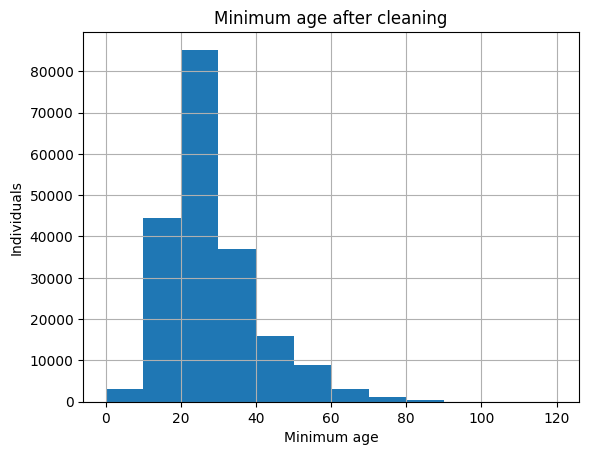

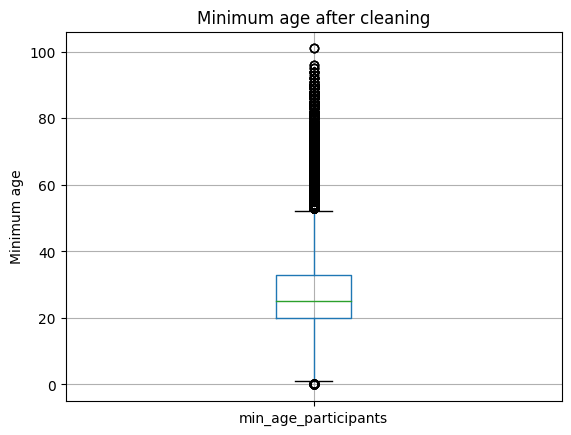

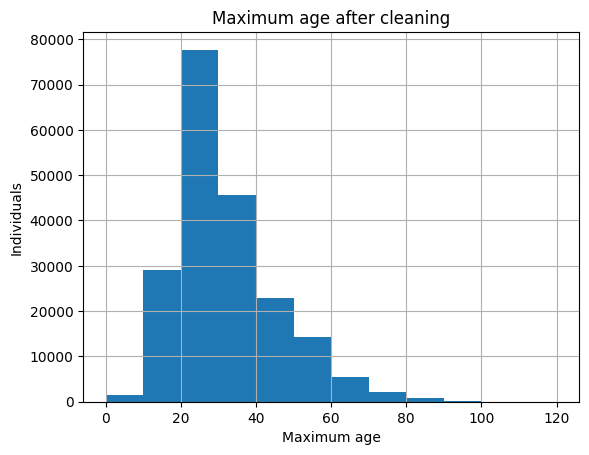

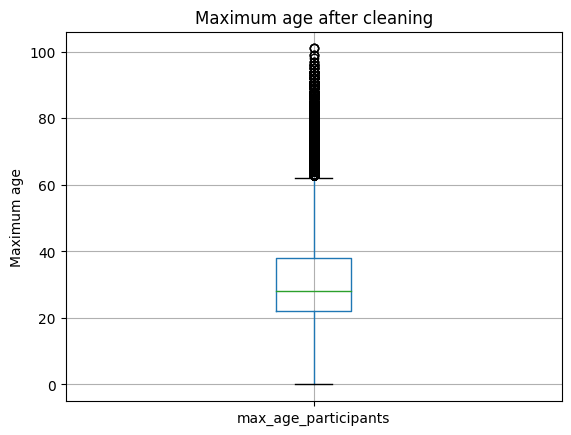

In [386]:
df.hist(column="min_age_participants", bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
plt.title("Minimum age after cleaning")
plt.xlabel("Minimum age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column="min_age_participants")
plt.title("Minimum age after cleaning")
plt.ylabel("Minimum age")
plt.show()

df.hist(column="max_age_participants", bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
plt.title("Maximum age after cleaning")
plt.xlabel("Maximum age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column="max_age_participants")
plt.title("Maximum age after cleaning")
plt.ylabel("Maximum age")
plt.show()

## Date

Analysis and cleaning of the date attribute

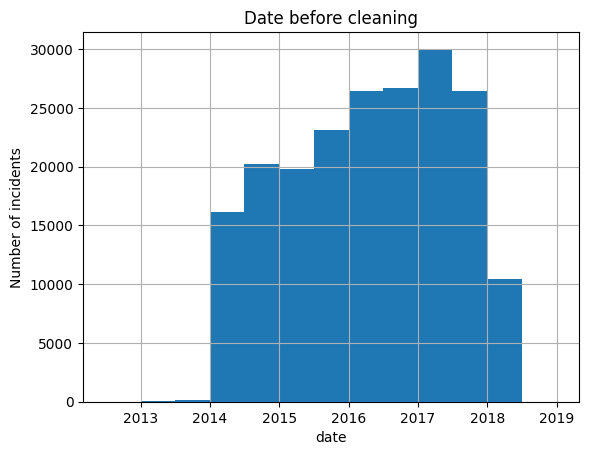

In [387]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

We considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data

In [390]:
""" #setting nan the longitudes and latitudes that are not in the US
df.loc[(df["latitude"] > 64.85694) | (df["latitude"] < 19.50139), ("latitude", "longitude")] = np.nan
df.loc[(df["longitude"] < -161.75583) | (df["longitude"] > -68.01197), ("longitude" , "latitude")] = np.nan """
#TODO: in DU cover all america

# Geographical info

## Latitude and longitude

We consider the triple <date,latitude,longitude> to be identifying of the incident. So we decided to remove all records that had all these three values to NaN

In [391]:
print(len(df))
#print duplicates columns if they are not NaN
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(len(df))

199378
198167


## Filling of missing values and outliers

In [392]:
#Sostituisco i valori NaN di latitude e longitude, con i valori delle righe aventi lo stesso state e la stessa city_or_county
df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"],group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state",group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198167 entries, 66818 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       198167 non-null  datetime64[ns]
 1   state                      198167 non-null  string        
 2   city_or_county             198167 non-null  string        
 3   address                    184771 non-null  string        
 4   latitude                   198167 non-null  float64       
 5   longitude                  198167 non-null  float64       
 6   congressional_district     198167 non-null  Int64         
 7   state_house_district       177094 non-null  Int64         
 8   state_senate_district      183086 non-null  Int64         
 9   participant_age1           135551 non-null  Int64         
 10  participant_age_group1     160568 non-null  string        
 11  participant_gender1        165953 non-null  string   

# Participant quantity information 
('n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants')

#TODO to check..

In [393]:
# Calculate the values to substitute, utilizza n_females, n_males
#Utilizzerà questi valori per sosituire "n_participants" nel caso somma tra male e female è pari alla somma tra teen,child e adults.
#La modifica per quanto riguarda "n_participants" è fatta solo se è diversa da tutte le altre somme delle varie colonne:
#1) females + males
#2) child + adult + teen
#3) killed+injured+unharmed+arrested
#Nel caso in cui n_partiicpants sia almeno uguale ad una delle altre somme => lascia uguale.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) & # TODO: not correct
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_females'] + df['n_males']) == (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198167 entries, 66818 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       198167 non-null  datetime64[ns]
 1   state                      198167 non-null  string        
 2   city_or_county             198167 non-null  string        
 3   address                    184771 non-null  string        
 4   latitude                   198167 non-null  float64       
 5   longitude                  198167 non-null  float64       
 6   congressional_district     198167 non-null  Int64         
 7   state_house_district       177094 non-null  Int64         
 8   state_senate_district      183086 non-null  Int64         
 9   participant_age1           135551 non-null  Int64         
 10  participant_age_group1     160568 non-null  string        
 11  participant_gender1        165953 non-null  string   

In [394]:
# Calculate the values to substitute, utilizza harmed,killed,unharmed,injured per la condizione di somma.
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) &
    ((df['n_females'] + df['n_males']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_females'] + df['n_males']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 198167 entries, 66818 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       198167 non-null  datetime64[ns]
 1   state                      198167 non-null  string        
 2   city_or_county             198167 non-null  string        
 3   address                    184771 non-null  string        
 4   latitude                   198167 non-null  float64       
 5   longitude                  198167 non-null  float64       
 6   congressional_district     198167 non-null  Int64         
 7   state_house_district       177094 non-null  Int64         
 8   state_senate_district      183086 non-null  Int64         
 9   participant_age1           135551 non-null  Int64         
 10  participant_age_group1     160568 non-null  string        
 11  participant_gender1        165953 non-null  string   

In [395]:
# Calculate the values to substitute, teen,adult e child con injured,killed,unharmed,arrested come condizione, e adult,teen,child come sostituto.
df['substitute_values'] = (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])

# Define the condition for substitution
condition = (
    (df['n_participants'] != (df['n_females'] + df['n_males'])) &
    (df['n_participants'] != (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen'])) &
    (df['n_participants'] != (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])) &
    ((df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested']) == (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen']))
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[
        (df['n_participants'] != (df["n_females"] + df["n_males"])) & 
        (df['n_participants'] != (df["n_participants_adult"] + df["n_participants_child"] + df["n_participants_teen"])) &
        (df["n_participants"] != (df["n_killed"] + df["n_injured"] + df["n_unharmed"] + df["n_arrested"])
    ) &
    (
        (df['n_participants_adult'] + df['n_participants_child'] + df['n_participants_teen']) == (df['n_killed'] + df['n_injured'] + df['n_unharmed'] + df['n_arrested'])
    )
][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult", "n_killed", "n_injured", "n_unharmed", "n_arrested"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198167 entries, 66818 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       198167 non-null  datetime64[ns]
 1   state                      198167 non-null  string        
 2   city_or_county             198167 non-null  string        
 3   address                    184771 non-null  string        
 4   latitude                   198167 non-null  float64       
 5   longitude                  198167 non-null  float64       
 6   congressional_district     198167 non-null  Int64         
 7   state_house_district       177094 non-null  Int64         
 8   state_senate_district      183086 non-null  Int64         
 9   participant_age1           135551 non-null  Int64         
 10  participant_age_group1     160568 non-null  string        
 11  participant_gender1        165953 non-null  string   

# Poverty by State

Import the povertyByStateYear csv file

In [ ]:
poverty_df = pd.read_csv('povertyByStateYear.csv', sep=',')
poverty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              884 non-null    object 
 1   year               884 non-null    int64  
 2   povertyPercentage  832 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ KB


Change data types to match the content of each attribute

In [ ]:
poverty_df["state"] = poverty_df["state"].astype("string")
poverty_df["year"] = poverty_df["year"].astype("Int64")

# Year State District House

Import the year_state_district_house csv file

In [ ]:
district_in_state_df = pd.read_csv('year_state_district_house.csv', sep=',')
district_in_state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    10441 non-null  int64 
 1   state                   10441 non-null  object
 2   congressional_district  10441 non-null  int64 
 3   party                   10441 non-null  object
 4   candidatevotes          10441 non-null  int64 
 5   totalvotes              10441 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 489.5+ KB


Change data types to match the content of each attribute

In [ ]:
district_in_state_df["state"] = district_in_state_df["state"].astype("string")
district_in_state_df["year"] = district_in_state_df["year"].astype("Int64")
district_in_state_df["congressional_district"] = district_in_state_df["congressional_district"].astype("Int64")
district_in_state_df["party"] = district_in_state_df["party"].astype("string")
district_in_state_df["candidatevotes"] = district_in_state_df["candidatevotes"].astype("Int64")
district_in_state_df["totalvotes"] = district_in_state_df["totalvotes"].astype("Int64")

In [ ]:

df['year'] = pd.DatetimeIndex(df['date']).year 


In [ ]:
#How many males are involved in incidents w.r.t. the total number of males for the
#same city and in the same period?
df["males_percentage"] = df["n_males"] /  df.groupby(["year","state", "city_or_county"])["n_males"].transform("sum")
df["males_percentage"]

33        0.015152
84        0.086957
122           <NA>
292            0.5
308           0.25
            ...   
239672    0.014925
239673    0.044444
239674    0.001052
239675    0.008811
239676         0.0
Name: males_percentage, Length: 238352, dtype: Float64

In [ ]:
#How many killed people have been involved w.r.t the total killed people in
# the same congressional district in a given period of time?
df["killed_percentage"] = df["n_killed"] /  df.groupby(["year","state", "congressional_district" ])["n_killed"].transform("sum")
df["killed_percentage"]

33        <NA>
84        <NA>
122       <NA>
292       <NA>
308       <NA>
          ... 
239672     0.0
239673     0.0
239674     0.0
239675     0.0
239676     0.0
Name: killed_percentage, Length: 238352, dtype: Float64

In [ ]:
#How many injured people have been involved w.r.t the total injured people in
# the same congressional district in a given period of time?
df["injured_percentage"] = df["n_injured"] /  df.groupby(["year","state", "congressional_district" ])["n_injured"].transform("sum")


In [ ]:
#Ratio of the number of the killed people in the incidents w.r.t. the number of
#participants in the incident
df["killed_percentage_per_incident"] = df["n_killed"] / df["n_participants"]
df[["n_killed", "n_participants", "killed_percentage_per_incident"]]

,n_killed,n_participants,killed_percentage_per_incident
33,1,1,1.0
84,0,2,0.0
122,0,0,NaN
292,0,3,0.0
308,1,2,0.5
...,...,...,...
239672,0,1,0.0
239673,0,3,0.0
239674,0,1,0.0
239675,0,2,0.0


In [ ]:
#Ratio of unharmed people in the incidents w.r.t. the the average of unharmed people
#in the same period
df["unharmed_percentage"] = df["n_unharmed"] / df.groupby(["year"])["n_unharmed"].transform("mean")
df[["n_unharmed", "unharmed_percentage"]]

,n_unharmed,unharmed_percentage
33,0,0.0
84,0,0.0
122,<NA>,<NA>
292,0,0.0
308,0,0.0
...,...,...
239672,0,0.0
239673,3,7.060887
239674,0,0.0
239675,1,2.349609
